In [1]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import random

# Anna
### Takes an image of a tissue slice and an image of an epithelium extract from Qupath an inputs

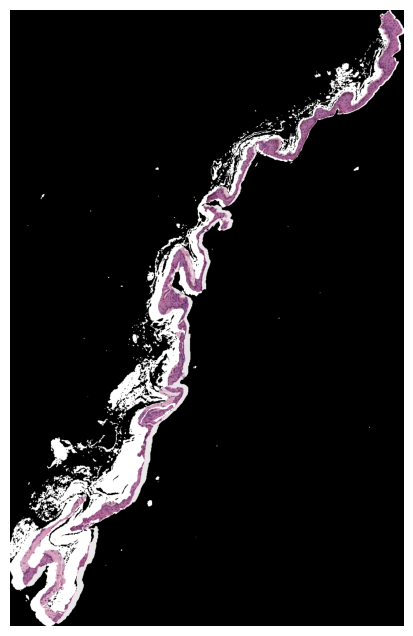

In [95]:
def apply_mask():

    # Open the JPG and PNG images
    jpg_path = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/thumbnail2.jpg' # path to the tissue slice
    png_mask_path = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/h2114183 h&e_ROI_3-labels.png' # path to the epithelium slice
    
    jpg_image = Image.open(jpg_path).convert("RGB")
    png_mask = Image.open(png_mask_path).convert("RGBA")

    # Resize the mask to match the JPG dimensions if they differ
    if jpg_image.size != png_mask.size:
        png_mask = png_mask.resize(jpg_image.size, Image.LANCZOS)

    # Convert both images to numpy arrays
    jpg_array = np.array(jpg_image)
    mask_array = np.array(png_mask)

    stroma_mask = ~np.all(jpg_array[:, :, :3] > 200, axis=-1)
    image = np.ones_like(jpg_array) * 255  # everything white
    image[~stroma_mask] = 0

    # Create a mask for pixels that are epithelium
    # A pixel is considered white if its RGB values are all greater than a threshold (200)
    e_mask = ~np.all(mask_array[:, :, :3] > 200, axis=-1)

    image[e_mask] = jpg_array[e_mask]

    # Convert back to PIL image for display
    masked_jpg_image = Image.fromarray(image)
    return masked_jpg_image

   

epithelium = apply_mask()
filename = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/output.png' # where you want your output to go
epithelium.save(filename)

# Display the final image
plt.figure(figsize=(8, 8))
plt.imshow(epithelium)
plt.axis("off")
plt.show()


# Kota

### Using Alyssa's code as a base, dynamically changing the initial_size parameter to make patches more efficient

Tissue orientation: vertical


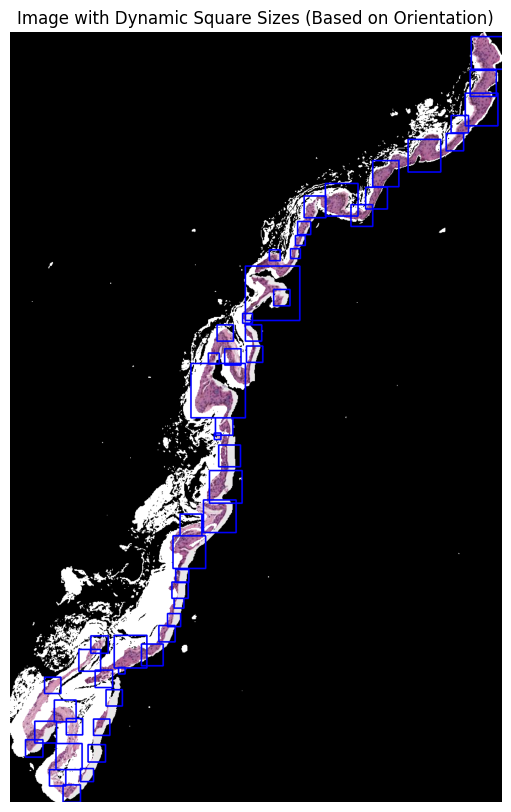

In [100]:
# Load the image
image_path = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/output.png'
image = cv2.imread(image_path)

# Function to check if a region contains black, white, and non-black-white mask
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Mask for black areas, white areas, and non-black-white pixels
black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Calculate distance to the nearest black and white pixels
black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

# Find coordinates of non-black and non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Define the ratio tolerance range for balanced points
min_ratio, max_ratio = 0.7, 1.3

# Filter coordinates to only include balanced points
balanced_points = [
    coord for coord in coordinates
    if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
]

# Function to determine tissue orientation
def determine_orientation(mask):
    # Find non-zero epithelium pixels
    non_zero_coords = np.column_stack(np.where(mask > 0))
    y_min, y_max = non_zero_coords[:, 0].min(), non_zero_coords[:, 0].max()
    x_min, x_max = non_zero_coords[:, 1].min(), non_zero_coords[:, 1].max()
    # Compare height and width of the bounding box
    height = y_max - y_min
    width = x_max - x_min
    return "vertical" if height > width else "horizontal"

# Determine tissue orientation
tissue_orientation = determine_orientation(non_black_white_mask)
print(f"Tissue orientation: {tissue_orientation}")

# Updated function to calculate epithelium width
def calculate_epithelium_width(row_or_col, mask, orientation):
    if orientation == "horizontal":
        # Use vertical slice for horizontally oriented tissue
        slice_mask = mask[:, row_or_col]
    else:
        # Use horizontal slice for vertically oriented tissue
        slice_mask = mask[row_or_col, :]

    # Convert the mask slice to binary (0 or 1)
    binary_slice = (slice_mask > 0).astype(int)

    # Count the maximum number of consecutive ones (nonzero values)
    max_width = 0
    current_width = 0
    for value in binary_slice:
        if value == 1:
            current_width += 1
            max_width = max(max_width, current_width)
        else:
            current_width = 0

    return max_width

# Function to calculate overlap
def calculate_overlap(new_coords, existing_coords):
    overlap = len(new_coords.intersection(existing_coords)) / len(new_coords)
    return overlap

# Initialize variables
max_attempts = 1000
covered_coordinates = set()
rectangles = []
attempts = 0

def compute_epithelium_widths(mask, orientation):
    widths = []
    if orientation == "horizontal":
        # Compute widths for each column
        for col in range(mask.shape[1]):
            widths.append(calculate_epithelium_width(col, mask, orientation))
    else:
        # Compute widths for each row
        for row in range(mask.shape[0]):
            widths.append(calculate_epithelium_width(row, mask, orientation))
    return np.array(widths)


all_widths = compute_epithelium_widths(non_black_white_mask, tissue_orientation)

q1 = np.percentile(all_widths, 25)  
q2 = np.percentile(all_widths, 50)  
q3 = np.percentile(all_widths, 75)

# Start generating squares using only balanced points as starting locations
while len(balanced_points) > 0 and attempts < max_attempts:
    attempts += 1
    # Randomly select a new center point for the square from balanced points
    random.seed(attempts)
    random_coord = random.choice(balanced_points)
    center_x, center_y = int(random_coord[1]), int(random_coord[0])

    # Dynamically calculate the initial_size based on epithelium width
    if tissue_orientation == "horizontal":
        epithelium_width = calculate_epithelium_width(center_x, non_black_white_mask, tissue_orientation)
    else:
        epithelium_width = calculate_epithelium_width(center_y, non_black_white_mask, tissue_orientation)
    
    # Dynamically adjust initial_size based on the width's quantile
    if epithelium_width < q1:
        initial_size = 3  
    elif epithelium_width < q2:
        initial_size = 5  
    elif epithelium_width < q3:
        initial_size = 8  
    else:
        initial_size = 10 

    num_squares_drawn = 0
    vertical_preference = False

    # Expansion phase for square
    while True:
        size = initial_size * (num_squares_drawn + 1)
        top, bottom = center_y - size, center_y + size
        left, right = center_x - size, center_x + size

        # Define regions at each corner of the square
        corner_checks = {
            "top_left": (top, left),
            "top_right": (top, right - initial_size),
            "bottom_left": (bottom - initial_size, left),
            "bottom_right": (bottom - initial_size, right - initial_size)
        }

        # Track how many corners are outside the mask
        corners_outside_count = 0

        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                corners_outside_count += 1
                continue

            # Extract the corner region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
            if not np.any(corner_region):
                corners_outside_count += 1

            if corners_outside_count >= 2:
                break

        if corners_outside_count >= 2:
            break  # Stop expanding

        num_squares_drawn += 1
        if num_squares_drawn > 13:  # Limit expansion if square becomes too large
            break

    # Get all coordinates in the current square
    new_square_coords = set((y, x) for y in range(max(0, top), min(image.shape[0], bottom))
                                    for x in range(max(0, left), min(image.shape[1], right)))
        
    # Check overlap with existing covered coordinates
    if calculate_overlap(new_square_coords, covered_coordinates) <= 0.12:
        covered_coordinates.update(new_square_coords)
        rectangles.append((left, top, right, bottom))

        # Draw the rectangle
        color = (0, 255, 0) if vertical_preference else (255, 0, 0)
        cv2.rectangle(image, (left, top), (right, bottom), color, 2)

        # Remove these coordinates from the non-black-white mask list and balanced points
        coordinates = np.array([coord for coord in coordinates if tuple(coord) not in new_square_coords])
        balanced_points = [coord for coord in balanced_points if tuple(coord) not in new_square_coords]

# Display the resulting image with all rectangles
plt.figure(figsize=(10, 10))
plt.title("Image with Dynamic Square Sizes (Based on Orientation)")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

lengths = []

for i, (left, top, right, bottom) in enumerate(rectangles, 1):
    length = bottom - top  # Height of the rectangle
    width = right - left   # Width of the rectangle
    lengths.append(length)

#print(f"Rectangle {i} dimensions: Length = {length} pixels, Width = {width} pixels")